In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SBBBBBSB'
m='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [5]:
from pyspark import SparkContext
# sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [6]:
data_dir='../../Data/Weather'
file_index='SBBBBBSB'

In [7]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [8]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    482.0|    49.3|   -99.45|       PRCP|CA005010191|     2|[00 00 00 00 00 0...|1985.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       PRCP|CA005010191|     0|[00 40 80 4F 00 0...|1986.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       PRCP|CA005010191|     2|[00 00 00 00 00 0...|1987.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       PRCP|CA005010191|     3|[00 46 00 44 00 0...|1988.0|SBBBBBSB|
|    482.0|    49.3|   -99.45|       PRCP|CA005010191|     4|[00 00 80 4F 00 0...|1989.0|SBBBBBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [9]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(3861, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

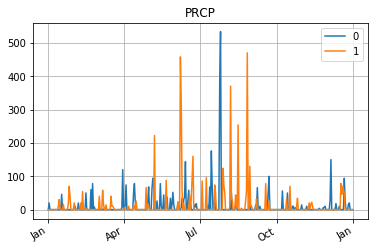

In [10]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

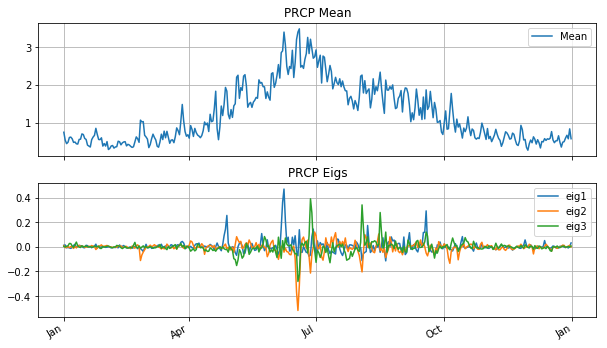

In [11]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

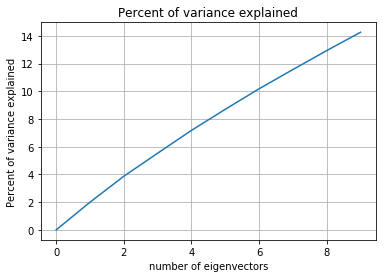

In [14]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');
fig.savefig('result_plots/Percent of variance explained'+m)

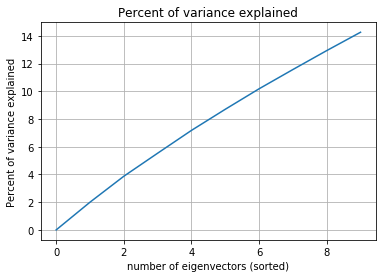

In [35]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals=np.sort(eigvals)[::-1]; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors (sorted)')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [16]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.972335434896
residual normalized norm  after mean + top eigs: [ 0.99935334  0.99904856  0.99698109]


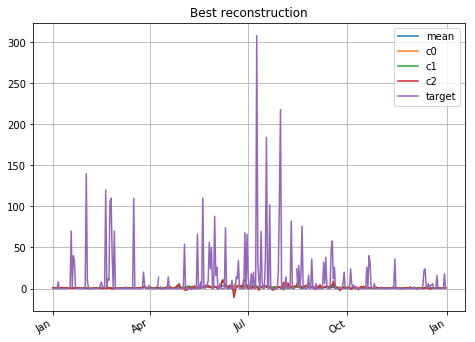

In [17]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [18]:
def decompose(row, Mean=Mean, v=v):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [19]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row,Mean,v)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

res_mean : 0.979184486589 res_1 : 0.999467515905 res_2 : 0.961806505539 res_3 : 0.813115632035
res_mean : 0.977941994876 res_1 : 0.997056845717 res_2 : 0.997053619197 res_3 : 0.939317323959
res_mean : 0.972335434896 res_1 : 0.99935334457 res_2 : 0.999048555837 res_3 : 0.996981087598


In [20]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

# WHY DOES THIS FILTERING AND WHAT REALLY DOES IT MEAN?

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 3861
after filter 3861


In [21]:
df3.columns

['coeff_1',
 'coeff_2',
 'coeff_3',
 'elevation',
 'label',
 'latitude',
 'longitude',
 'measurement',
 'res_1',
 'res_2',
 'res_3',
 'res_mean',
 'station',
 'total_var',
 'undefs',
 'vector',
 'year']

In [39]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [47]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10), fig_title=None):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    fig.suptitle(fig_title, fontsize=15)
    fig.savefig('result_plots/' + fig_title)
    return None


In [41]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+-------------------+-------------------+
|          res_mean|             res_1|              res_2|              res_3|
+------------------+------------------+-------------------+-------------------+
|0.9839584444598176|0.9997435909554429| 0.4449483623366685|0.39480872138618833|
|0.9812753631002443|0.5136554263033527|0.48597563331961596|0.48575424016604757|
|0.9832996688573163|0.9991083192113637| 0.5284571365539913| 0.5033716274050015|
|0.9763473516132495|0.9910729201064485| 0.9121244978477261| 0.5224739600565582|
+------------------+------------------+-------------------+-------------------+
only showing top 4 rows



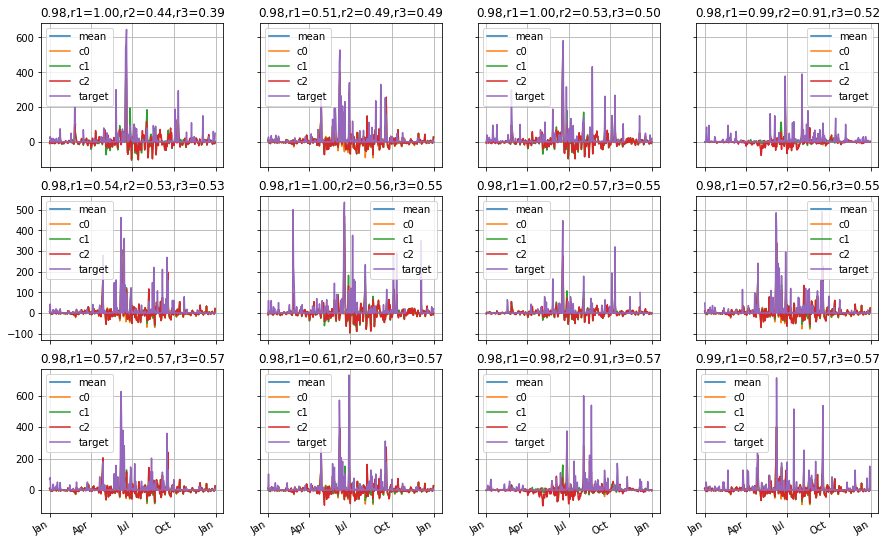

In [42]:
plot_recon_grid(rows)

In [43]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.9796081495970517|0.9999834294732358|0.9999206211203681|0.9999202692539091|
|  0.96945152097054|0.9999708109013801|0.9999541389207921|0.9998926763698036|
|0.9815284785561255| 0.999865545581446|0.9998648888782892|0.9998654610634709|
|0.9830651111953669|0.9999398854108653|  0.99986233706126|0.9997779888594196|
+------------------+------------------+------------------+------------------+
only showing top 4 rows



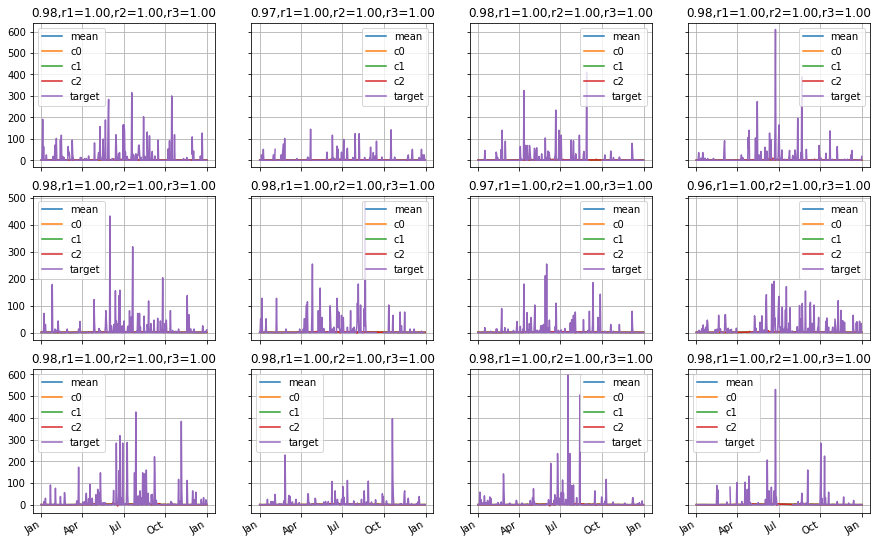

In [44]:
plot_recon_grid(rows)

# Big residue res_1

In [48]:
df4=df3.sort(df3.res_1, ascending=False)
rows=df4.take(12)
df4.select('coeff_1','res_1').show(4)

+-------------------+------------------+
|            coeff_1|             res_1|
+-------------------+------------------+
|-3.9493863662804896|1.0000134946747963|
|-1.1344013005576559|1.0000095127361548|
|0.17428757259600736|1.0000002141669566|
|0.04420295474138382|0.9999999961654682|
+-------------------+------------------+
only showing top 4 rows



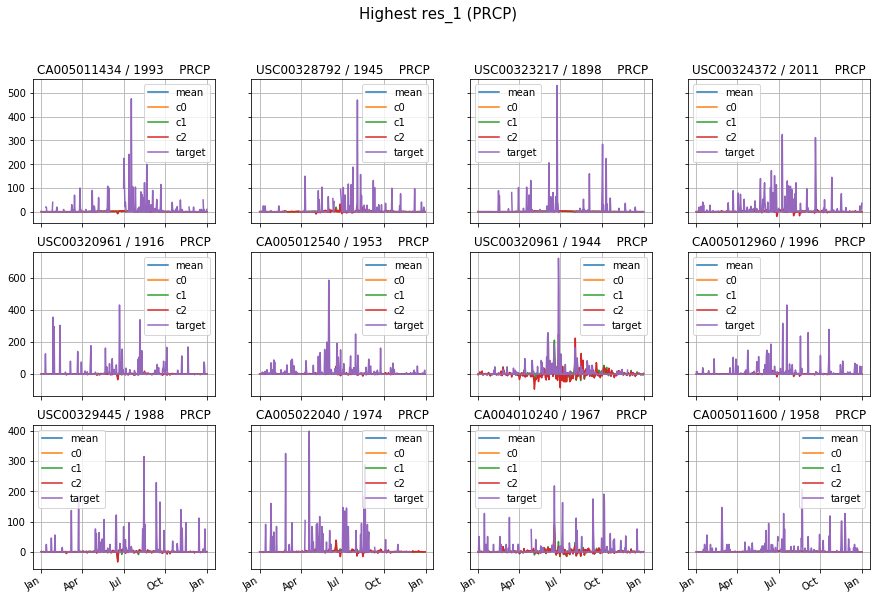

In [49]:
plot_recon_grid(rows, fig_title='Highest res_1 (PRCP)')

# Less residue res_1

In [50]:
df4=df3.sort(df3.res_1, ascending=True)
rows=df4.take(12)
df4.select('coeff_1', 'coeff_2', 'coeff_3', 'res_1').show(4)

+-----------------+-------------------+------------------+------------------+
|          coeff_1|            coeff_2|           coeff_3|             res_1|
+-----------------+-------------------+------------------+------------------+
|830.0960993720363|-198.03308572219166|17.710810204457207|0.5136554263033527|
|637.3291651960229| -93.05752445582085| 39.43632558342709|0.5403555092863354|
|788.0699817933139| -45.22919683246084|52.979428381690596|0.5707283681920738|
|705.7007678422625|-109.01173767971947| 99.55979808638482|  0.57277510058538|
+-----------------+-------------------+------------------+------------------+
only showing top 4 rows



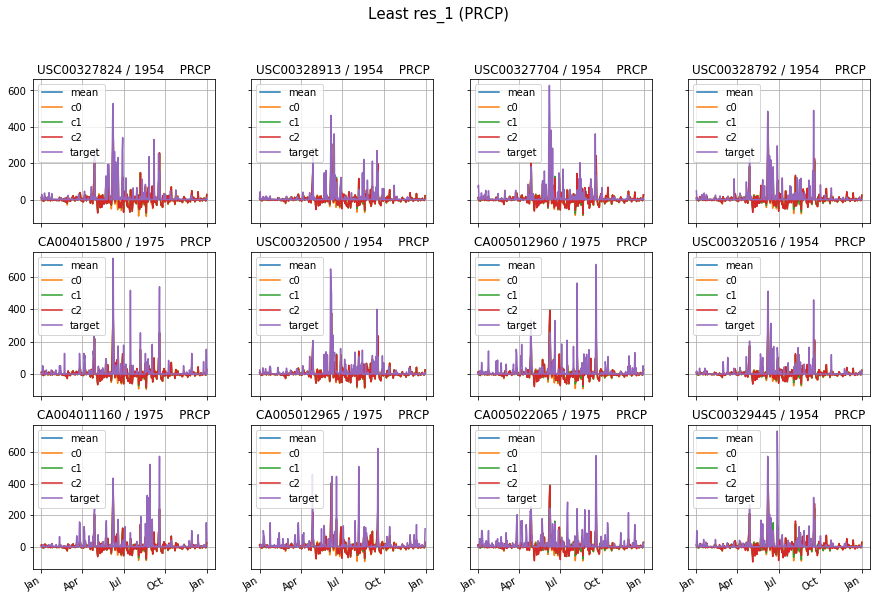

In [51]:
plot_recon_grid(rows, fig_title='Least res_1 (PRCP)')

# Big residue res_3

In [52]:
df4=df3.sort(df3.res_3, ascending=False)
rows=df4.take(12)
df4.select('coeff_3','res_3').show(4)

+-------------------+------------------+
|            coeff_3|             res_3|
+-------------------+------------------+
| 0.4544430987728314|0.9999202692539091|
|  3.110890237379243|0.9998926763698036|
|-0.5751590365237986|0.9998654610634709|
|  -8.36578027958123|0.9997779888594196|
+-------------------+------------------+
only showing top 4 rows



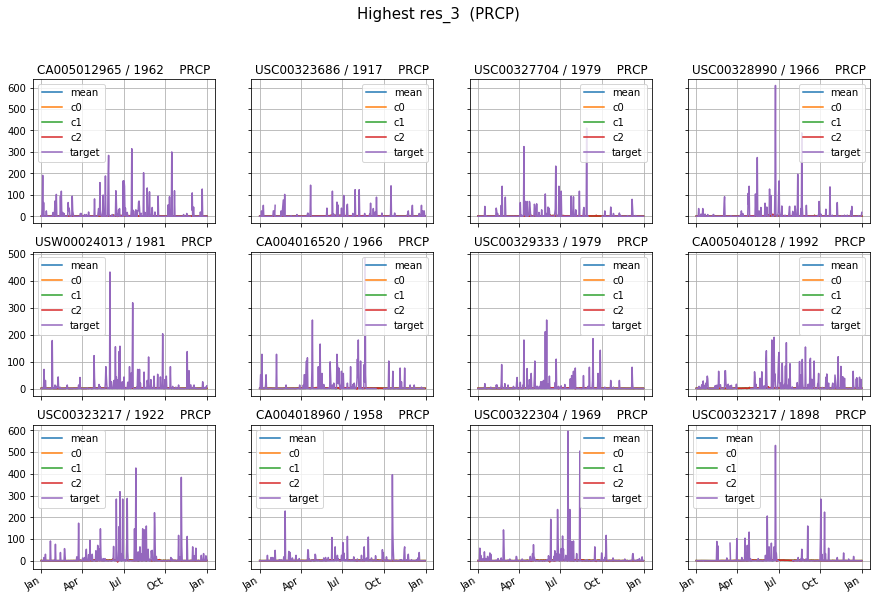

In [53]:
plot_recon_grid(rows, fig_title='Highest res_3  (PRCP)')

# Less residue res_3

In [54]:
df4=df3.sort(df3.res_3, ascending=True)
rows=df4.take(12)
df4.select('coeff_1', 'coeff_2', 'coeff_3','res_3').show(4)

+------------------+-------------------+-------------------+-------------------+
|           coeff_1|            coeff_2|            coeff_3|              res_3|
+------------------+-------------------+-------------------+-------------------+
|18.213366189845477| -904.7484224461937|-282.46467272423496|0.39480872138618833|
| 830.0960993720363|-198.03308572219166| 17.710810204457207|0.48575424016604757|
|36.815272355840435| -844.2175641715811|-195.47457700375884| 0.5033716274050015|
|-68.04984856247161|-202.76740837246336|  447.5459678973569| 0.5224739600565582|
+------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



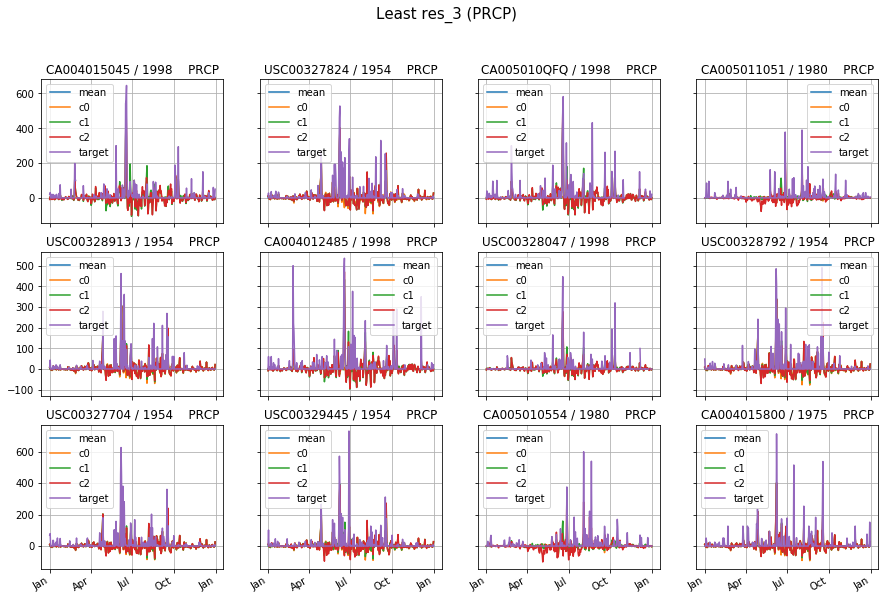

In [55]:
plot_recon_grid(rows, fig_title='Least res_3 (PRCP)')

# Big Positive coeff_1

In [56]:
df4=df3.sort(df3.coeff_1, ascending=False)
rows=df4.take(12)
df4.select('coeff_1','res_1').show(4)
# More coeff_1 less res_1 as both have similar shape

+-----------------+------------------+
|          coeff_1|             res_1|
+-----------------+------------------+
|853.9492375904828|0.6542828616229579|
|841.7074774968445|0.5771029449595868|
|839.2006609985343|0.5999013178347897|
|830.0960993720363|0.5136554263033527|
+-----------------+------------------+
only showing top 4 rows



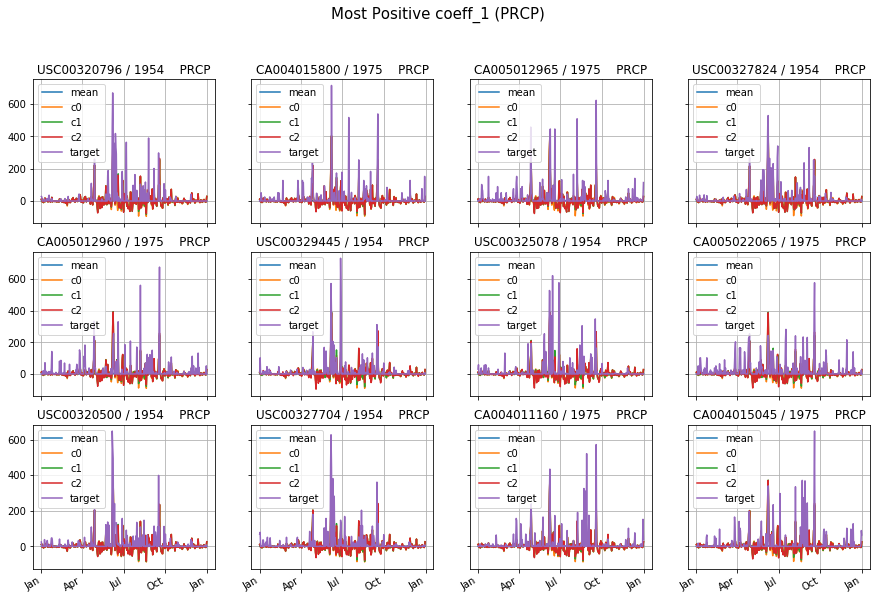

In [57]:
plot_recon_grid(rows, fig_title='Most Positive coeff_1 (PRCP)')

# Big Negative coeff_1

In [58]:
df4=df3.sort(df3.coeff_1, ascending=True)
rows=df4.take(12)
df4.select('coeff_1','res_1').show(4)

+-------------------+------------------+
|            coeff_1|             res_1|
+-------------------+------------------+
| -248.7491318426464|0.9590748959380874|
| -203.2157823645155|0.9699494058256167|
|-201.10162017888263|0.9761907920770385|
| -193.6896645396187|0.9723893589751901|
+-------------------+------------------+
only showing top 4 rows



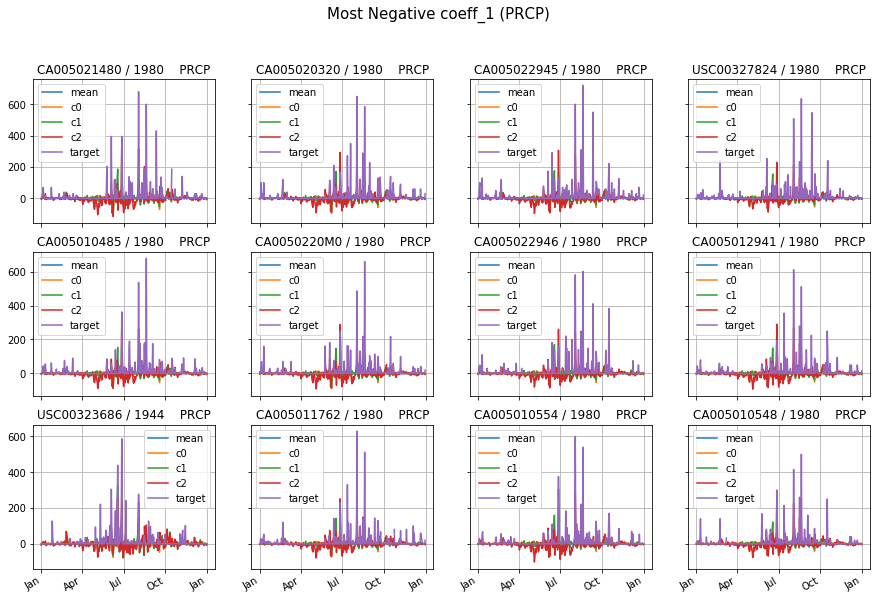

In [59]:
plot_recon_grid(rows, fig_title='Most Negative coeff_1 (PRCP)')

# Big Positive coeff_2

In [60]:
df4=df3.sort(df3.coeff_2, ascending=False)
rows=df4.take(12)
df4.select('coeff_2','res_2').show(4)

+------------------+------------------+
|           coeff_2|             res_2|
+------------------+------------------+
|240.58830225907423|0.9620719206302647|
| 233.3267673369461|0.9677891228363487|
|222.15642859521117|0.9609938070078011|
| 197.5107882423723|0.9676108381948497|
+------------------+------------------+
only showing top 4 rows



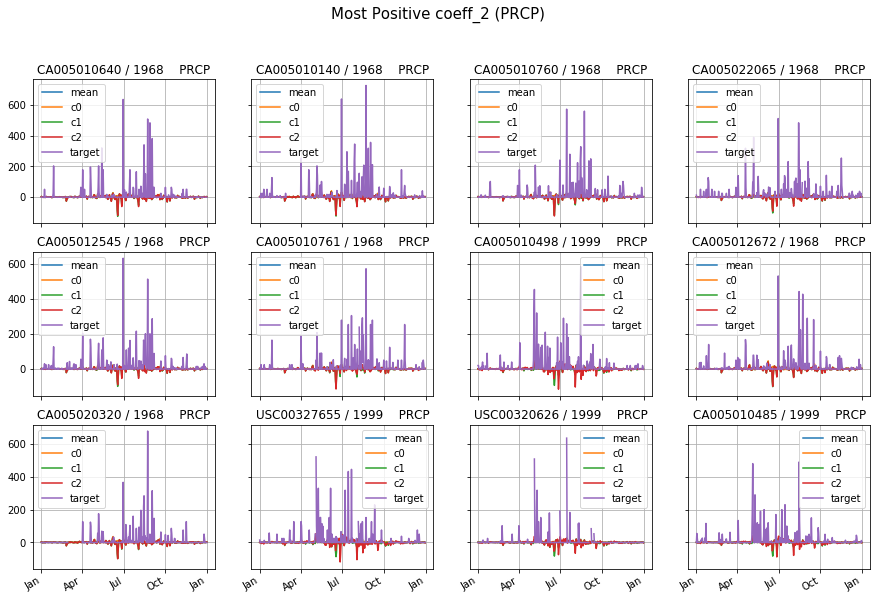

In [61]:
plot_recon_grid(rows, fig_title='Most Positive coeff_2 (PRCP)')

# Big Negative coeff_2

In [62]:
df4=df3.sort(df3.coeff_2, ascending=True)
rows=df4.take(12)
df4.select('coeff_1','res_1').show(4)

+-------------------+------------------+
|            coeff_1|             res_1|
+-------------------+------------------+
| 18.213366189845477|0.9997435909554429|
| 36.815272355840435|0.9991083192113637|
|-59.371212847157295|0.9977061241656281|
|  31.22122969354251|0.9994035975272857|
+-------------------+------------------+
only showing top 4 rows



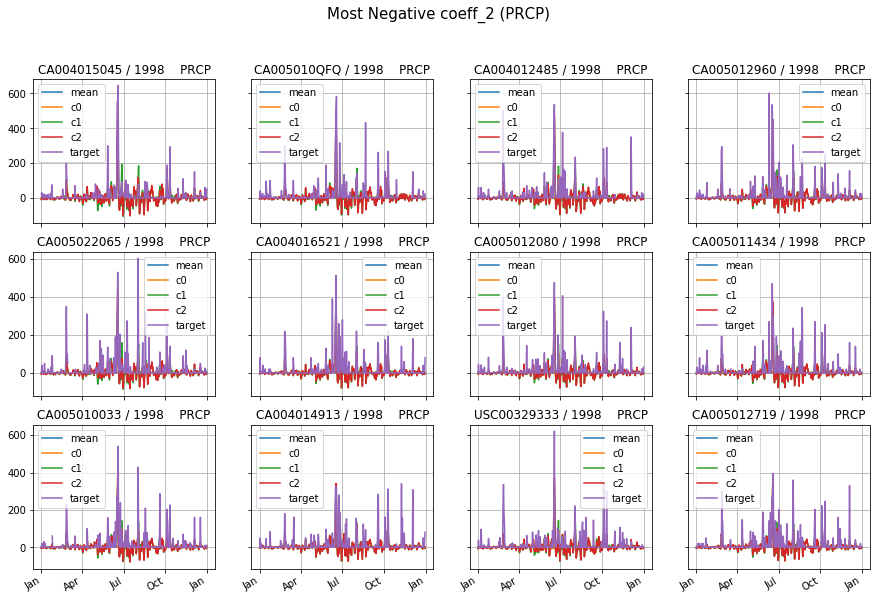

In [63]:
plot_recon_grid(rows, fig_title='Most Negative coeff_2 (PRCP)')

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

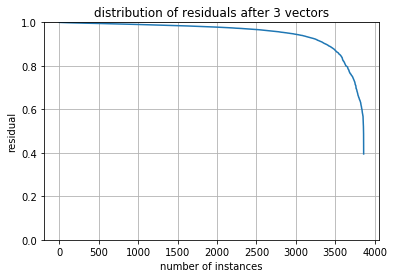

In [28]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [36]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
#     vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+ feat + ' for '+ m)
    ylabel('number of instances')
    xlabel(feat)
    grid()
    savefig('result_plots/cumulative distribution of '+feat + ' for '+ m)

# Show difference between PRCP and SNWD

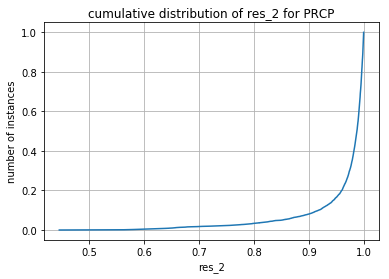

In [37]:


plot_CDF('res_2')

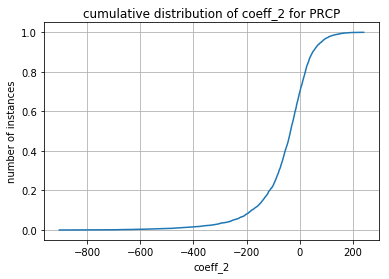

In [38]:
plot_CDF('coeff_2')

In [30]:
R3

[0.9999202692539091,
 0.9998926763698036,
 0.9998654610634709,
 0.9997779888594196,
 0.999771020525574,
 0.9997699019454194,
 0.9997344849429868,
 0.9997170479991677,
 0.9996816359406075,
 0.9996639751117677,
 0.999649491050059,
 0.9996305488243051,
 0.999613765013677,
 0.9996012604150379,
 0.9995933858698702,
 0.9995911468618958,
 0.9995886769718344,
 0.9995317631035284,
 0.999522406485166,
 0.9994767696277095,
 0.9994738960068591,
 0.9994541052269832,
 0.9994407208654702,
 0.999430215032083,
 0.9994095858806524,
 0.9994002743857255,
 0.999392120835021,
 0.9993914564346011,
 0.9993888009461193,
 0.9993794413738532,
 0.9993770563282983,
 0.9993724102123317,
 0.9993618456297603,
 0.999358796167893,
 0.9993400334418091,
 0.9993223419991982,
 0.9993093495824004,
 0.9992935884404751,
 0.9992890211367128,
 0.9992798520676914,
 0.9992676921581574,
 0.9992588222150721,
 0.9992575657042114,
 0.9992560553789689,
 0.9992365293021462,
 0.9992360417527968,
 0.9992067568588692,
 0.9992021195381106,

In [42]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [43]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.4M	../../Data/Weather/US_Weather_SBBBBBSB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.9M	../../Data/Weather/decon_SBBBBBSB_PRCP.parquet
2.3M	../../Data/Weather/decon_SBBBBBSB_SNWD.parquet
